# COVID-19 Forecasting in US

### CS 4774 Final Project

## Allen Lang (al8he)

This is the notebook for my final project on COVID-19 forecasting using Facebook Prophet. i will be attempting to build a time-series model that will be able to forecast new cases in the United States using historical data of this pandemic earlier this year. Here is an outline of the notebook:

## Outline<a class="anchor" id="0"></a>
1. [Introduction](#1)
1. [Prophet Basics](#2)
1. [Hyperparameter Tuning without Holidays](#3)
1. [Hyperparameter Tuning with Holidays](#4)
    - [National Holidays](#4.1)
    - [Adding Special Events](#4.2)
    - [Manual Tuning](#4.3)
1. [Hyperparameter Tuning with Regressors](#5)
1. [Consolidation and Prediction](#6)

Datasets used:
- NYT COVID-19 cases: https://www.kaggle.com/paultimothymooney/nytimes-covid19-data
- National holidays for countries: https://github.com/dr-prodigy/python-holidays
- Oxford stringency index: https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker
- Google Mobility Report: https://www.google.com/covid19/mobility/

# 1. Introduction<a class="anchor" id="1"></a>
[Back to Outline](#0)

The following libraries are to be imported. Numpy, math, and Pandas were used for data processing and handling. Facebook Prophet was used for modeling the timeseries. Sklearn was used for machine learning operations like splitting data. Plotly was used for data visualizations. 

In [1]:
import pandas as pd

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

import plotly.express as px
import numpy as np
import math

## Dataset: COVID-19 Cases/Deaths in United States

The imported dataset is from the New York Times: https://www.kaggle.com/paultimothymooney/nytimes-covid19-data. Reads in total cases and deaths per date for the US. Other datasets will be introduced when they are relevant later on the notebook.

In [2]:
df_covid_us = pd.read_csv('covidinus/historical/us.csv')
df_covid_us

date     cases  deaths
0    2020-01-21         1       0
1    2020-01-22         1       0
2    2020-01-23         1       0
3    2020-01-24         2       0
4    2020-01-25         3       0
..          ...       ...     ...
309  2020-11-25  12851220  262157
310  2020-11-26  12954324  263336
311  2020-11-27  13159784  264748
312  2020-11-28  13311031  265940
313  2020-11-29  13447344  266758

[314 rows x 3 columns]

The original values are total cases and deaths, so a function converts those values into differences between the previous and current day. This is accomplished using the diff() function for Panda DataFrames. It is then checked for any missing values (there will be at least one since a difference was taken). Additionally, the date column is converted into Pandas's DateTime format because it is required for Prophet models.

In [3]:
def format_df(df):
    df['new cases'] = df.loc[:,'cases'].diff()
    df['new deaths'] = df.loc[:,'deaths'].diff()

    # removing missing values
    if np.sum(df.isnull().sum()) > 0:
        print("There exist missing values")
    
    df.loc[0,'new cases']=0
    df.loc[0,'new deaths']=0
    
    if np.sum(df.isnull().sum()) == 0:
        print("They have been removed")
    
    df.dtypes
    df['date'] = pd.DatetimeIndex(df['date'])
    return df

df_covid_us = format_df(df_covid_us)
df_covid_us

There exist missing values
They have been removed


date     cases  deaths  new cases  new deaths
0   2020-01-21         1       0        0.0         0.0
1   2020-01-22         1       0        0.0         0.0
2   2020-01-23         1       0        0.0         0.0
3   2020-01-24         2       0        1.0         0.0
4   2020-01-25         3       0        1.0         0.0
..         ...       ...     ...        ...         ...
309 2020-11-25  12851220  262157   180536.0      2313.0
310 2020-11-26  12954324  263336   103104.0      1179.0
311 2020-11-27  13159784  264748   205460.0      1412.0
312 2020-11-28  13311031  265940   151247.0      1192.0
313 2020-11-29  13447344  266758   136313.0       818.0

[314 rows x 5 columns]

This is a line chart depicting the trend of new cases per day in the United States over the course of the pandemic's official monitoring. The COVID-19 cases seem to have spiked during the fall season and seems to be ever increasing.

In [4]:
fig =px.line(df_covid_us,x='date',y='new cases',title='Daily New COVID-19 Cases in the US')
fig.show()

# 2. Basic Prophet<a class="anchor" id="2"></a>
[Back to Outline](#0)

For basics, Prophet will only fit DataFramse that have time column named "ds" and the output column named "y". Additionally, the function will start the dataframe at February 15th because that is when Google's Mobility Report starts. The introduction of Google Mobility Report data sets will be later in section 5.

In [5]:
def make_proph_df(df):
    p = df.loc[25:,['date','new cases']]
    p.columns= ['ds','y']
    return p

df_proph = make_proph_df(df_covid_us)
df_proph

ds         y
25  2020-02-15       0.0
26  2020-02-16       0.0
27  2020-02-17      10.0
28  2020-02-18       0.0
29  2020-02-19       0.0
..         ...       ...
309 2020-11-25  180536.0
310 2020-11-26  103104.0
311 2020-11-27  205460.0
312 2020-11-28  151247.0
313 2020-11-29  136313.0

[289 rows x 2 columns]

The following is just a simplistic use of a Prophet model with the default parameters. It will fit onto the DataFrame above and then produce a model that fits onto the data. Additionally, it will also predict the next 15 days. The graph is shown below, as well as existence of seasonalities for weekly and yearly metrics. By observation, the current model does a very poor job at fitting to the time-series data. There does appear to be a weekly seasonality such that Fridays see the greatest increase in case numbers compared to the rest of the week while the weekend (Saturday/Sunday) have the least. The resulting train and test RMSE:
- Train RMSE: 11186.339480457511 
- Test RMSE: 73059.2327144311

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11186.339480457511 73059.2327144311


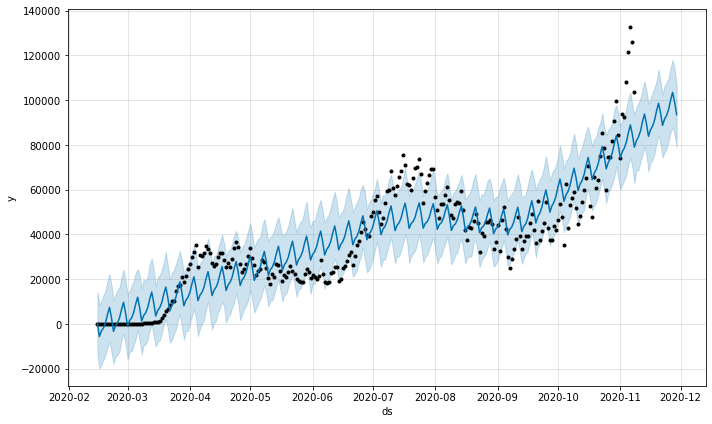

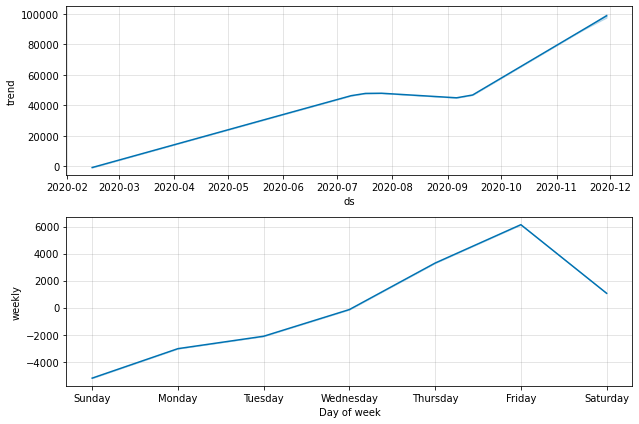

In [6]:
def baseline(df):
    tr,te = train_test_split(df,test_size=0.07,shuffle=False)

    basic_mod = Prophet()
    basic_mod.fit(tr)
    future_dates = basic_mod.make_future_dataframe(periods=te.shape[0])    
    forecast = basic_mod.predict(future_dates)
    basic_mod.plot(forecast);
    basic_mod.plot_components(forecast);   
    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    print(training_rmse,test_rmse)   
    return

baseline(df_proph)

# 3. Hyperparameter Tuning Part 1: Without Holidays<a class="anchor" id="3"></a>
[Back to Outline](#0)

The total dataset will first be split into a training set and a testing set, for which the training set will be used to find the best parameters.

In [7]:
train,test = train_test_split(make_proph_df(df_covid_us),test_size=0.07,shuffle=False)

First, the model will be tuned without the inclusion of any holidays or special events. These involve tuning the changepoints that influence trend and the seasonality.

Below are the various parameters that will be used to finetune the model. 
- Seasonality: type of seasonality
- Seasonality scale: flexibility of seasonality
- Changepoint scale: flexibility of trend between changepoints
- Fourier order: order of the Fourier series used for seasonality

In [8]:
seasonality_type_list = ['additive','multiplicative']
seasonality_prior_scale_list = [0.1,1,10]
changepoint_prior_scale_list = [0.1, 0.2, 0.3, 0.5]
weekly_fourier_order_list = [6, 8, 10, 12] 

The tuning will go through each of these parameters and select the best combination that will minimize the root mean squared error for the testing set. It stores the parameter combinations in a dictionary called "best_params".

In [9]:
def part1_model_training(df, season_type, season_scale, changepoint_scale,fourier):
    tr,te = train_test_split(df,test_size=0.07,shuffle=False)

    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, 
                    changepoint_prior_scale = changepoint_scale,seasonality_mode=season_type)                   
    model.add_seasonality(name='weekly', period=7, fourier_order=fourier, mode = season_type, 
                              prior_scale = season_scale)
    model.fit(tr)
    future_dates = model.make_future_dataframe(periods=te.shape[0])
    forecast = model.predict(future_dates)
    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    
    return training_rmse,test_rmse

def part1_tuning(train,season_list,season_scale_list, change_scale_list,fourier_list,):
    tr_rmse_list=[]
    te_rmse_list=[]
    best_params_rmse = {'season':'','season scale':'','changepoint scale':'','fourier order':''}
    best_rmse= math.inf
    for season_type in season_list:
        for season_scale in season_scale_list:
            for changepoint_scale in change_scale_list:
                for fourier in fourier_list:
                    tr_rmse,te_rmse = part1_model_training(train,season_type,season_scale,changepoint_scale,fourier)
                    tr_rmse_list.append(tr_rmse)
                    te_rmse_list.append(te_rmse)
                    print('season:', season_type,'season scale:', season_scale,'changepoint scale:',changepoint_scale,
                          'fourier order:',fourier)
                    print('curr:',te_rmse,'best:',best_rmse)
                    print()
                    if best_rmse > te_rmse:
                        best_rmse = te_rmse
                        best_params_rmse['season']=season_type
                        best_params_rmse['season scale']=season_scale
                        best_params_rmse['changepoint scale']=changepoint_scale
                        best_params_rmse['fourier order']=fourier
    pd.DataFrame(data=[tr_rmse_list,te_rmse_list]).T.to_csv("hyperparameter.csv")
    return best_params_rmse

grading_mode=True

if not grading_mode:
    best_params= part1_tuning(train,seasonality_type_list,
                              seasonality_prior_scale_list,changepoint_prior_scale_list,weekly_fourier_order_list)
else:
    best_params = {'season': 'multiplicative', 'season scale': 10, 'changepoint scale': 0.5, 'fourier order': 12}

The hyperparameter tuning performance is now plotted on a 3D scatter plot, with season and changepoint scale on x and y axis, respectively. Fourier order is represented as a difference in color. The root mean squared error of the test set is shown on the z axis, so performance is measured by height. The last parameter, seasonality type, is plotted on two different scatterplots. By inspection, the additive mode performed worse than the multiplicative mode.

In [10]:
def plot_part1_hyper():
    hyper=pd.read_csv('hyperparameter.csv')
    hyper['fourier order'] = hyper['fourier order'].astype(str)

    hyper_add = hyper.iloc[:hyper.shape[0]//2,:]
    hyper_mult = hyper.iloc[hyper.shape[0]//2:,:]

    fig_add = px.scatter_3d(hyper_add, x='season scale', y='changepoint scale', z='test_rmse',log_z=True,
                         color='fourier order', color_discrete_sequence= px.colors.sequential.Plasma_r, opacity=1,
                        title='Results of Part 1 hyperparameter tuning additive mode')
    fig_add.update_layout(scene = dict(xaxis = dict(nticks=3),yaxis = dict(nticks=4)))
    fig_add.update(layout=dict(title=dict(x=0.5)))
    fig_add.show()
    
    fig_mult = px.scatter_3d(hyper_mult, x='season scale', y='changepoint scale', z='test_rmse',
                         color='fourier order', color_discrete_sequence= px.colors.sequential.Plasma_r, opacity=1,
                        title='Results of Part 1 hyperparameter tuning multiplicative mode')
    fig_mult.update_layout(scene = dict(xaxis = dict(nticks=3),yaxis = dict(nticks=4)))
    fig_mult.update(layout=dict(title=dict(x=0.5)))
    fig_mult.show()
    return

plot_part1_hyper()

Here is a summary of part 1's hyperparameter tuning:

Part 1 non holiday hyperparameter tuning
Tested on: 
Seasonality types: ['additive', 'multiplicative']
Seasonality scale: [0.1, 1, 10]
Changepoint scale: [0.1, 0.2, 0.3, 0.5]
Fourier Order: [6, 8, 10, 12]

Best Performance came from: 
season multiplicative
season scale 10
changepoint scale 0.5
fourier order 12

3171.630202890555 32726.623025682835


C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



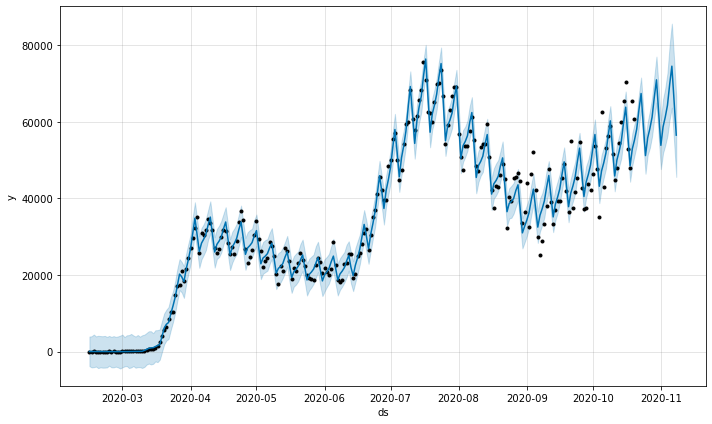

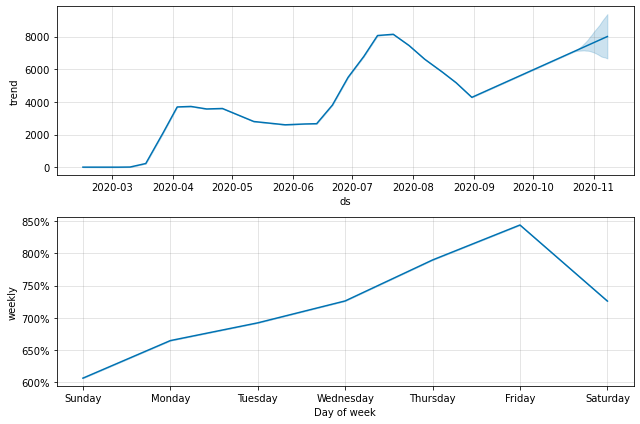

In [11]:
def part1_summary(df, best_params):
    tr,te = train_test_split(df,test_size=0.07,shuffle=False)

    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, 
                    changepoint_prior_scale = best_params['changepoint scale'],seasonality_mode=best_params['season'])
    model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier order'], mode = best_params['season'], 
                              prior_scale = best_params['season scale'])
    model.fit(tr)

    print("Part 1 non holiday hyperparameter tuning")
    print("Tested on: ")
    print("Seasonality types:",seasonality_type_list)
    print("Seasonality scale:", seasonality_prior_scale_list)
    print("Changepoint scale:", changepoint_prior_scale_list)
    print("Fourier Order:", weekly_fourier_order_list)
    print()
    print("Best Performance came from: ")
    for i in best_params:
        print(i,best_params[i])
    print()
    
    future_dates = model.make_future_dataframe(periods=te.shape[0])
    forecast = model.predict(future_dates)
    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    print(training_rmse,test_rmse)
    
    model.plot(forecast);
    model.plot_components(forecast);
    return 

best_params = {'season': 'multiplicative', 'season scale': 10, 'changepoint scale': 0.5, 'fourier order': 12}
part1_summary(train, best_params)

### Part 1 Summary
Best parameters:
- Seasonality: multiplicative
- Seasonality scale: 10
- Changepoint scale: 0.5
- Fourier order: 12

RMSE:
- Train: 3171.630202890555
- Test: 32726.623025682835

# 4. Hyperparameter Tuning Parts 2, 3, 4: With Holidays<a class="anchor" id="4"></a>
[Back to Outline](#0)

Section 4 covers hyperparameter tuning with the inclusion of holidays. The first subsection involves imported national holidays. The second includes special events added by myself. The third includes an attempt to manually tune each individual holiday parameter based on intuition. 

## 4.1 Part 2: National Holidays<a class="anchor" id="4.1"></a>
[Back to Outline](#0)

The holidays csv used is taken from this repo: https://github.com/dr-prodigy/python-holidays. 

In [12]:
h = pd.read_csv('holidays.csv')
h

ds_holidays                                            holiday  \
0    2020-02-24                   Día de Carnaval [Carnival's Day]   
1    2020-02-25                   Día de Carnaval [Carnival's Day]   
2    2020-03-24  Día Nacional de la Memoria por la Verdad y la ...   
3    2020-04-09  Semana Santa (Jueves Santo)  [Holy day (Holy T...   
4    2020-04-10  Semana Santa (Viernes Santo)  [Holy day (Holy ...   
..          ...                                                ...   
755  2020-05-09  Victory Day and Commemoration of the Fallen He...   
756  2020-06-01                                     Children's Day   
757  2020-08-27                                   Independence Day   
758  2020-08-31                              National Language Day   
759  2020-12-25                                      Christmas Day   

             ds    country code country_official_name  lower_window  \
0    2020-03-02  Argentina   AR    Argentine Republic            -3   
1    2020-03-03  Argentina   AR    Argentine Republic            -3   
2    2020-03-31  Argentina   AR    Argentine Republic            -3   
3    2020-04-16  Argentina   AR    Argentine Republic            -3   
4    2020-04-17  Argentina   AR    Argentine Republic            -3   
..          ...        ...  ...                   ...           ...   
755  2020-05-16    Moldova   MD   Republic of Moldova            -3   
756  2020-06-08    Moldova   MD   Republic of Moldova            -3   
757  2020-09-03    Moldova   MD   Republic of Moldova            -3   
758  2020-09-07    Moldova   MD   Republic of Moldova            -3   
759  2021-01-01    Moldova   MD   Republic of Moldova            -3   

     upper_window  prior_scale  \
0               3           10   
1               3           10   
2               3           10   
3               3           10   
4               3           10   
..            ...          ...   
755             3           10   
756             3           10   
757             3           10   
758             3           10   
759             3           10   

                                                source  
0        https://github.com/dr-prodigy/python-holidays  
1        https://github.com/dr-prodigy/python-holidays  
2        https://github.com/dr-prodigy/python-holidays  
3        https://github.com/dr-prodigy/python-holidays  
4        https://github.com/dr-prodigy/python-holidays  
..                                                 ...  
755  https://en.wikipedia.org/wiki/Public_holidays_...  
756  https://en.wikipedia.org/wiki/Public_holidays_...  
757  https://en.wikipedia.org/wiki/Public_holidays_...  
758  https://en.wikipedia.org/wiki/Public_holidays_...  
759  https://en.wikipedia.org/wiki/Public_holidays_...  

[760 rows x 10 columns]

The following function then cleans up this table and selects holidays only celebrated by the United States. Independence Day and Independence Day (Observed) were assumed similar and thus dropped. Prophet requires holiday dataframes to have 'ds' for time and 'holiday' for holidays, so this function also formats the dataframe as such.

In [13]:
def make_holiday_df():
    holiday = pd.read_csv('holidays.csv').drop(columns='source')
    us_holidays=holiday[holiday.country=='United States'].loc[:,['ds_holidays','holiday']]
    us_holidays=us_holidays.drop(index=686)
    us_holidays.columns=['ds','holiday']
    us_holidays['ds'] = pd.DatetimeIndex(us_holidays['ds'])
    us_holidays.index=np.arange(us_holidays.shape[0])
    return us_holidays

make_holiday_df()

ds                holiday
0 2020-02-17  Washington's Birthday
1 2020-05-25           Memorial Day
2 2020-07-04       Independence Day
3 2020-09-07              Labor Day
4 2020-10-12           Columbus Day
5 2020-11-11           Veterans Day
6 2020-11-26           Thanksgiving
7 2020-12-25          Christmas Day

The model will now be tuned with the inclusion of these holidays. These involve tuning the how much holidays should matter and the exact window of each holiday. The other parameters were taken from Part 1's best set.

Below are the various parameters that will be used to finetune the model. 
- Lower window: how far the holiday goes backward (-1 means holiday is also celebrated day before)
- Upper window: how far the holiday goes forward (1 means holiday is also celebrated day after)
- Priority Scale: importance of each holiday as a "shock" to model

In [14]:
lower_window_list = [-1, -2, -3,-4]
upper_window_list = [1, 2, 3, 4]
prior_scale_list = [0.05, 1, 5, 10]

The tuning will go through each of these parameters and select the best combination that will minimize the root mean squared error for the testing set. It stores the parameter combinations in a dictionary called "best_params".

In [15]:
def part2_model_training(df, holi, best_params, lower_win, upper_win, holiday_scale):
    tr,te = train_test_split(df,test_size=0.07,shuffle=False)

    holi['lower_window']=lower_win
    holi['upper_window']=upper_win
    holi['prior_scale']=holiday_scale

    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False,holidays=holi, 
                    changepoint_prior_scale = best_params['changepoint scale']
                    )
    model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier order'], mode = best_params['season'], 
                              prior_scale = best_params['season scale'])
    model.fit(tr)
    future_dates = model.make_future_dataframe(periods=te.shape[0])
    forecast = model.predict(future_dates)
    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    
    return training_rmse,test_rmse


def part2_tuning(train, best_params, lowwin_list, upwin_list, scale_list):
    tr_rmse_list=[]
    te_rmse_list=[]
    best_rmse= math.inf
    for lower_win in lowwin_list:
        for upper_win in upwin_list:
            for holiday_prior_scale in scale_list:
                tr_rmse,te_rmse=part2_model_training(train,make_holiday_df(),best_params,lower_win,upper_win, holiday_prior_scale)
                tr_rmse_list.append(tr_rmse)
                te_rmse_list.append(te_rmse)
                print('lower_window', lower_win,'upper_win', upper_win,'prior_scale',holiday_prior_scale)
                print(te_rmse,best_rmse)
                print()
                if best_rmse > te_rmse:
                    best_rmse = te_rmse
                    best_params['lower_window']=lower_win
                    best_params['upper_window']=upper_win
                    best_params['prior_scale']=holiday_prior_scale
    pd.DataFrame(data=[tr_rmse_list,te_rmse_list]).T.to_csv("hyperparameter_holi.csv")
    return best_params

grading_mode=True
if not grading_mode:
    best_params = {'season': 'multiplicative', 'season scale': 10, 'changepoint scale': 0.5, 'fourier order': 12}

    best_params = part2_tuning(train,best_params,lower_window_list,upper_window_list,prior_scale_list)
else:
    best_params = {'changepoint scale': 0.5,  'fourier order': 12, 'lower_window': -4, 'prior_scale': 5,
                    'season': 'multiplicative',  'season scale': 10, 'upper_window': 1}
    

The hyperparameter tuning performance is now plotted on a 3D scatter plot, with lower and upper windows on x and y axis, respectively. Priority scale is represented as a difference in color. The root mean squared error of the test set is shown on the z axis, so performance is measured by height. By inspection, there seems to be a clear trend in which higher upper windows makes the model worse. However, the magnitude of the lower window increasing led to the error decreasing. Holiday priority scale seems to be influenced as well, since the worst performing window configurations did better when the scale was smaller (less influence). Best performing models had holidays be more influential.

In [16]:
def plot_part2_hyper():
    hyper_holi=pd.read_csv('hyperparameter_holi.csv')
    hyper_holi['scale'] = hyper_holi['scale'].astype(str)

    fig = px.scatter_3d(hyper_holi, x='lower', y='upper', z='test_rmse',
                         color='scale', color_discrete_sequence= px.colors.sequential.Plasma_r, opacity=1,
                        title='Results of Part 2 hyperparameter tuning')
    fig.update_layout(scene = dict(xaxis = dict(nticks=3),yaxis = dict(nticks=4),zaxis=dict(nticks=5)))
    fig.show()

plot_part2_hyper()

Here is a summary of part 2's hyperparameter tuning:

Part 2 holiday hyperparameter tuning
Tested on: 
Lower window: [-1, -2, -3, -4]
Upper window: [1, 2, 3, 4]
Holiday scale [0.05, 1, 5, 10]

Best Performance came from: 
changepoint scale 0.5
fourier order 12
lower_window -4
prior_scale 5
season multiplicative
season scale 10
upper_window 1
2886.2822857956885 32057.552066381282


C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



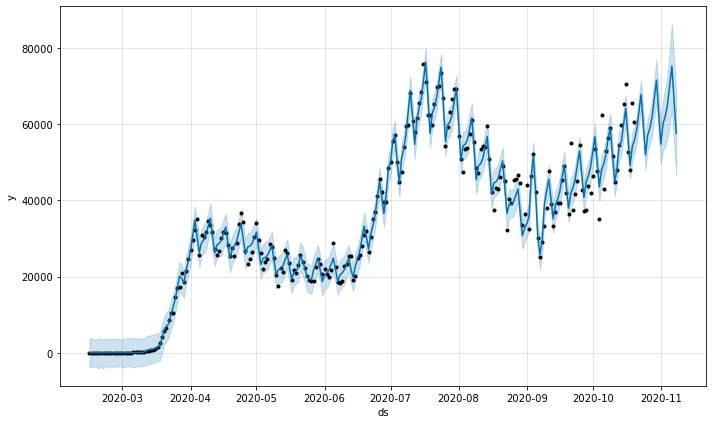

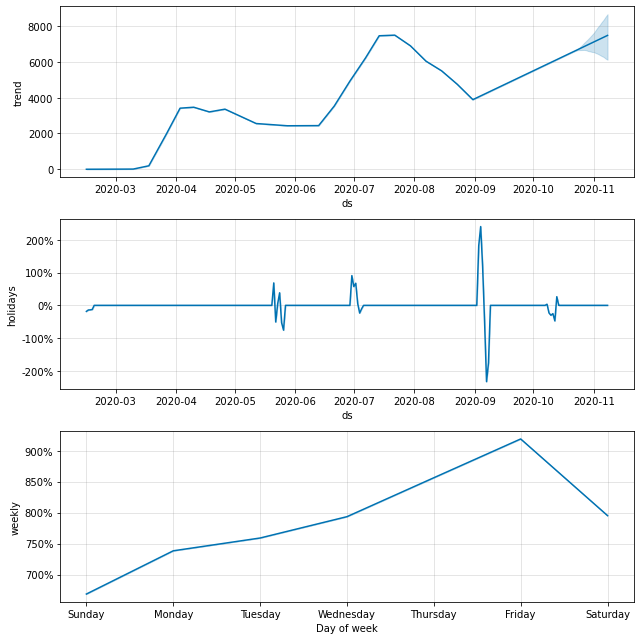

In [17]:
def part2_summary(df, holi,best_params):
    tr,te = train_test_split(df,test_size=0.07,shuffle=False)

    holi['lower_window']=best_params['lower_window']
    holi['upper_window']=best_params['upper_window']
    holi['prior_scale']=best_params['prior_scale']
    
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, holidays=holi,
                    changepoint_prior_scale = best_params['changepoint scale'],seasonality_mode=best_params['season'])
    model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier order'], mode = best_params['season'], 
                              prior_scale = best_params['season scale'])
    model.fit(tr)

    
    print("Part 2 holiday hyperparameter tuning")
    print("Tested on: ")
    print("Lower window:", lower_window_list)
    print("Upper window:", upper_window_list)
    print("Holiday scale", prior_scale_list)
    print()
    print("Best Performance came from: ")
    for i in best_params:
        print(i,best_params[i])
 
    future_dates = model.make_future_dataframe(periods=te.shape[0])
    forecast = model.predict(future_dates)
    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    print(training_rmse,test_rmse)
    
    model.plot(forecast);
    model.plot_components(forecast);
    return 

best_params = {'changepoint scale': 0.5,  'fourier order': 12, 'lower_window': -4, 'prior_scale': 5,
                'season': 'multiplicative',  'season scale': 10, 'upper_window': 1}
part2_summary(train, make_holiday_df(), best_params)

### Part 2 Summary
The model showed clear improvements in fitting the training data, as well as a marginal improvement in the testing data. The inclusion of holidays seems to improve the model's performance.

Best parameters:
- Seasonality: multiplicative
- Seasonality scale: 10
- Changepoint scale: 0.5
- Fourier order: 12
- Lower window: -4
- Upper window: 1
- Holiday Prior Scale: 5

RMSE:
- Train: 2886.2822857956885
- Test: 32057.552066381282

## 4.2 Adding Special Events<a class="anchor" id="4.2"></a>
[Back to Outline](#0)

The second section is more of an attempt to add custom holidays and special events to see if it improves the model. One aspect I thought would be loosening of restrictions on lockdown procedures. The govresponse csv is taken from https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker, and it contains four general metrics about government COVID-19 response.

In [18]:
def format_govresponse():
    trial = pd.read_csv('govresponse.csv')
    trial['date'] = pd.DatetimeIndex(trial['date'])
    trial=trial[(trial.date<='2020-12-01')&(trial.date >= '2020-02-15')]
    trial.index = np.arange(trial.shape[0])
    return trial

format_govresponse()

date  stringency  gov_response  containment  econ_supp
0   2020-02-15        5.56          7.14         8.33        0.0
1   2020-02-16        5.56          7.14         8.33        0.0
2   2020-02-17        5.56          7.14         8.33        0.0
3   2020-02-18        5.56          7.14         8.33        0.0
4   2020-02-19        5.56          7.14         8.33        0.0
..         ...         ...           ...          ...        ...
286 2020-11-27       75.46         74.40        76.39       62.5
287 2020-11-28       75.46         74.40        76.39       62.5
288 2020-11-29       75.46         74.40        76.39       62.5
289 2020-11-30       75.46         74.40        76.39       62.5
290 2020-12-01         NaN         74.40          NaN        NaN

[291 rows x 5 columns]

Stringency quantifies the strictness of lockdown policies. Government response is an average of all the other records in the Oxford database (https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker). Containment is a metric that quantifies the lockdown strictness along with the ability to test people and contact trace. Economic support measures how the government has provided financial support for those who have been impacted by the pandemic. With all four plotted, it seems that they are different by name but not by nature. Excluding economic support, which is a flatline, the other three all seem to follow similar patterns with each other.

In [19]:
def plot_four_metrics(df):
    fig = px.line(df,x='date',y=['stringency','gov_response','containment','econ_supp'])
    fig.show()

plot_four_metrics(format_govresponse())

Due to this observation, only the stringency metric will be focused on since it will also capture government response and containement. The function below checks to see, from the onset of lockdown, what days saw major drops in lockdown strictness. A total of four had been found.

In [20]:
def find_dates_relaxed():
    df = format_govresponse()
    df['stringency'] = df.loc[:,'stringency'].diff()
    relaxed = df.loc[df.stringency<0,['date','stringency']]
    relaxed.loc[:,'holiday'] = 'Lessening of Quarantine Measures'
    relaxed.columns=['ds','stringency','holiday']
    return relaxed

find_dates_relaxed()

ds  stringency                           holiday
121 2020-06-15       -3.71  Lessening of Quarantine Measures
156 2020-07-20       -1.85  Lessening of Quarantine Measures
210 2020-09-12       -4.63  Lessening of Quarantine Measures
254 2020-10-26       -3.70  Lessening of Quarantine Measures

These four lockdown loosening events will be added to the holiday DataFrame. Additionally, I wanted to see if BLM, Halloween (which wasn't actually part of the original), and the Election day had any affect on the model performance. I selected these because they are either holidays or special events that led to people gathering together in some sort. The new holiday DataFrame is shown here.

In [21]:
def make_new_holiday_df():
    quaran = find_dates_relaxed()
    quaran = quaran.drop(columns='stringency')
    updated_holi = make_holiday_df()
    updated_holi = updated_holi.append(quaran)
    
    special = pd.DataFrame({'ds':['2020-06-01','2020-10-31','2020-11-03'],'holiday':['BLM Protests','Halloween','Election Day']})
    special['ds'] = pd.DatetimeIndex(special['ds'])
    updated_holi = updated_holi.append(special)
    updated_holi = updated_holi.sort_values('ds')

    updated_holi.index = np.arange(updated_holi.shape[0])
    return updated_holi

make_new_holiday_df()

ds                           holiday
0  2020-02-17             Washington's Birthday
1  2020-05-25                      Memorial Day
2  2020-06-01                      BLM Protests
3  2020-06-15  Lessening of Quarantine Measures
4  2020-07-04                  Independence Day
5  2020-07-20  Lessening of Quarantine Measures
6  2020-09-07                         Labor Day
7  2020-09-12  Lessening of Quarantine Measures
8  2020-10-12                      Columbus Day
9  2020-10-26  Lessening of Quarantine Measures
10 2020-10-31                         Halloween
11 2020-11-03                      Election Day
12 2020-11-11                      Veterans Day
13 2020-11-26                      Thanksgiving
14 2020-12-25                     Christmas Day

The exact same procedure is done for section 4.1, just with the holiday DataFrame being a different one with extra holidays used. 

In [22]:
def part3_model_training(df, holi, best_params, lower_win, upper_win, holiday_scale):
    tr,te = train_test_split(df,test_size=0.07,shuffle=False)

    holi['lower_window']=lower_win
    holi['upper_window']=upper_win
    holi['prior_scale']=holiday_scale

    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False,holidays=holi, 
                    changepoint_prior_scale = best_params['changepoint scale']
                    )
    model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier order'], mode = best_params['season'], 
                              prior_scale = best_params['season scale'])
    model.add_seasonality(name='triply',period=3,fourier_order=best_params['fourier order'],mode=best_params['season'],prior_scale=best_params['season scale'])
    model.fit(tr)
    future_dates = model.make_future_dataframe(periods=te.shape[0])
    forecast = model.predict(future_dates)
    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    
    return training_rmse,test_rmse


def part3_tuning(train, best_params, lowwin_list, upwin_list, scale_list):
    tr_rmse_list=[]
    te_rmse_list=[]
    best_rmse= math.inf
    for lower_win in lowwin_list:
        for upper_win in upwin_list:
            for holiday_prior_scale in scale_list:
                tr_rmse,te_rmse=part3_model_training(train,make_new_holiday_df(),best_params,lower_win,upper_win, holiday_prior_scale)
                tr_rmse_list.append(tr_rmse)
                te_rmse_list.append(te_rmse)
                print('lower_window', lower_win,'upper_win', upper_win,'prior_scale',holiday_prior_scale)
                print(te_rmse,best_rmse)
                print()
                if best_rmse > te_rmse:
                    best_rmse = te_rmse
                    best_params['lower_window']=lower_win
                    best_params['upper_window']=upper_win
                    best_params['prior_scale']=holiday_prior_scale
    pd.DataFrame(data=[tr_rmse_list,te_rmse_list]).T.to_csv("hyperparameter_new_holi.csv")
    return best_params
                    
grading_mode = True
if grading_mode:
    best_params = {'changepoint scale': 0.5,  'fourier order': 12, 'lower_window': -4, 'prior_scale': 10,
                    'season': 'multiplicative',  'season scale': 10, 'upper_window': 1}
else:
    best_params = part3_tuning(train,best_params,lower_window_list,upper_window_list,prior_scale_list)


The hyperparameter tuning performance is now plotted on a 3D scatter plot, with lower and upper windows on x and y axis, respectively. Priority scale is represented as a difference in color. The root mean squared error of the test set is shown on the z axis, so performance is measured by height. By inspection, a similar trend seems to show with section 4.1 regarding a clear direction towards better performing models.

In [23]:
def plot_part3_hyper():
    hyper_holi=pd.read_csv('hyperparameter_new_holi.csv')
    hyper_holi['scale'] = hyper_holi['scale'].astype(str)

    fig = px.scatter_3d(hyper_holi, x='lower', y='upper', z='test_rmse',
                         color='scale', color_discrete_sequence= px.colors.sequential.Plasma_r, opacity=1,
                        title='Results of Part 3 hyperparameter tuning')
    fig.update_layout(scene = dict(xaxis = dict(nticks=3),yaxis = dict(nticks=4),zaxis=dict(nticks=5)))
    fig.show()

plot_part3_hyper()

This is a summary of section 4.2.

Part 3 holiday hyperparameter tuning
Tested on: 
Lower window: [-1, -2, -3, -4]
Upper window: [1, 2, 3, 4]
Holiday scale [0.05, 1, 5, 10]

Best Performance came from: 
changepoint scale 0.5
fourier order 12
lower_window -4
prior_scale 10
season multiplicative
season scale 10
upper_window 1

2786.0089033838062 32712.979338494726


C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



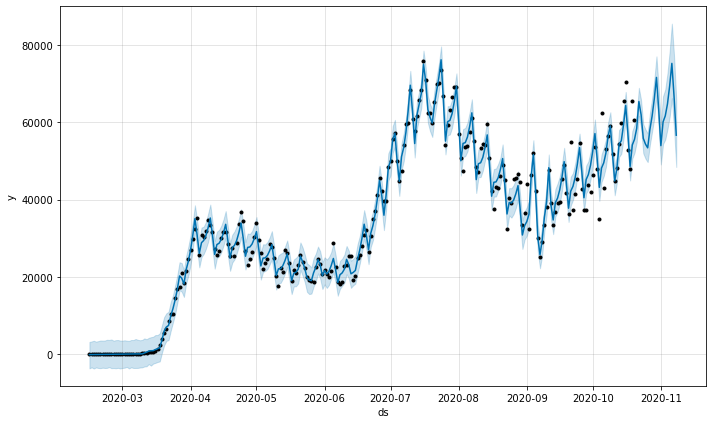

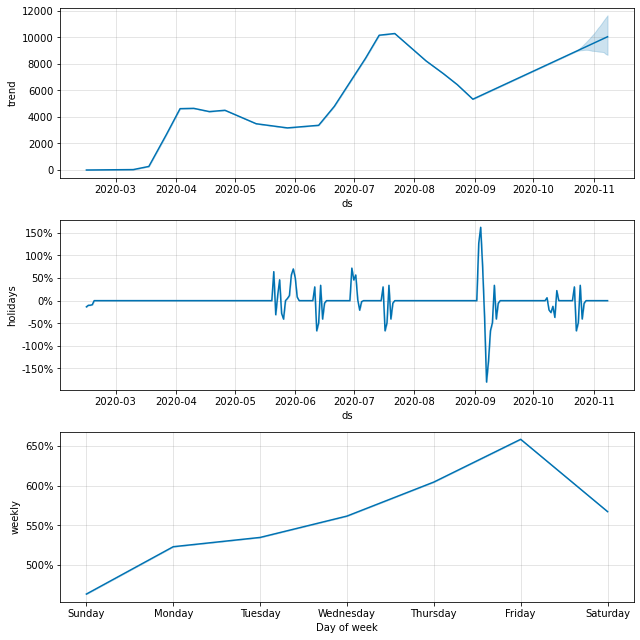

In [24]:
def part3_summary(df, holi,best_params):
    tr,te = train_test_split(df,test_size=0.07,shuffle=False)

    holi['lower_window']=best_params['lower_window']
    holi['upper_window']=best_params['upper_window']
    holi['prior_scale']=best_params['prior_scale']
    
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, holidays=holi,
                    changepoint_prior_scale = best_params['changepoint scale'],seasonality_mode=best_params['season'])
    model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier order'], mode = best_params['season'], 
                              prior_scale = best_params['season scale'])
    model.fit(tr)

    print("Part 3 holiday hyperparameter tuning")
    print("Tested on: ")
    print("Lower window:", lower_window_list)
    print("Upper window:", upper_window_list)
    print("Holiday scale", prior_scale_list)
    print()
    print("Best Performance came from: ")
    for i in best_params:
        print(i,best_params[i])
    print()
    
    future_dates = model.make_future_dataframe(periods=te.shape[0])
    forecast = model.predict(future_dates)
    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    print(training_rmse,test_rmse)
    
    model.plot(forecast);
    model.plot_components(forecast);
    return 

part3_summary(train,make_new_holiday_df(),best_params)

### Part 3 Summary
Despite performing better to the training data, the inclusion of these extra holidays actually worsened the model and caused it to overfit more. Compared to section 4.1, the parameters remained the same except for holiday prior scale which was a 10 instead of a 5. This change will not be included for the next section since it performed worse on the testing data.

Best parameters:
- Seasonality: multiplicative
- Seasonality scale: 10
- Changepoint scale: 0.5
- Fourier order: 12
- Lower window: -4
- Upper window: 1
- Holiday Prior Scale: 10

RMSE:
- Train: 2786.0089033838062
- Test: 32712.979338494726

In [25]:
best_params = {'changepoint scale': 0.5,  'fourier order': 12, 'lower_window': -4, 'prior_scale': 5,
                'season': 'multiplicative',  'season scale': 10, 'upper_window': 1}

## 4.3 Self-Tuning Holidays<a class="anchor" id="4.3"></a>
[Back to Outline](#0)

The last section was an attempt to manually tune the parameters for each single holiday. The past two sections have assigned the same window and prior scales to all of the holidays. However, holidays are not all celebrated equally. For example, Independence Day this year was on a Saturday, but maybe people took the day before off and people might continue festivities into the 5th because it is also a weekend. I also tried to tune the prior scale since a holiday like Thanksgiving is celebrated more frequently than a holiday like Veteran's Day.

In [26]:
pd.read_csv('myholidays.csv')

ds                           holiday  lower_window  upper_window  \
0    2/17/2020             Washington's Birthday             0             0   
1    5/25/2020                      Memorial Day            -2             0   
2     6/1/2020                      BLM Protests            -2             6   
3    6/15/2020  Lessening of Quarantine Measures            -1             1   
4     7/4/2020                  Independence Day            -1             1   
5    7/20/2020  Lessening of Quarantine Measures            -1             1   
6     9/7/2020                         Labor Day            -2             0   
7    9/12/2020  Lessening of Quarantine Measures            -1             1   
8   10/12/2020                      Columbus Day            -2             0   
9   10/26/2020  Lessening of Quarantine Measures            -1             1   
10  10/31/2020                         Halloween            -1             1   
11   11/3/2020                      Election Day            -1             3   
12  11/11/2020                      Veterans Day             0             0   
13  11/26/2020                      Thanksgiving            -1             2   
14  12/25/2020                     Christmas Day            -1             1   

    prior_scale  
0             1  
1             5  
2             5  
3             8  
4             9  
5             8  
6             8  
7             8  
8             3  
9             8  
10            8  
11            7  
12            3  
13           10  
14           10

No tuning was done for this section since I manually assigned values to each holiday.

3024.228191679621 32700.52890464703


C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



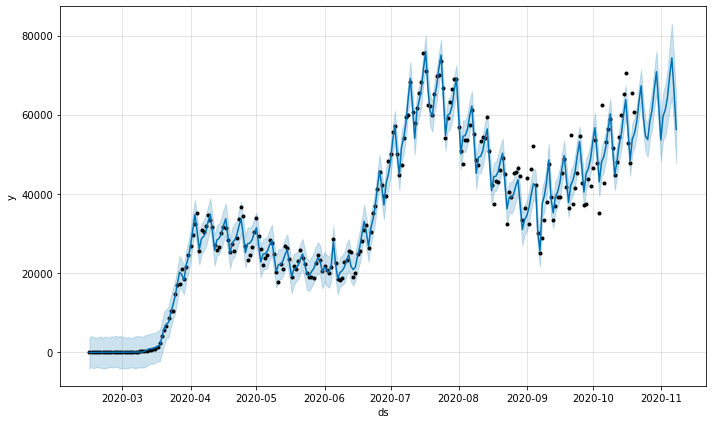

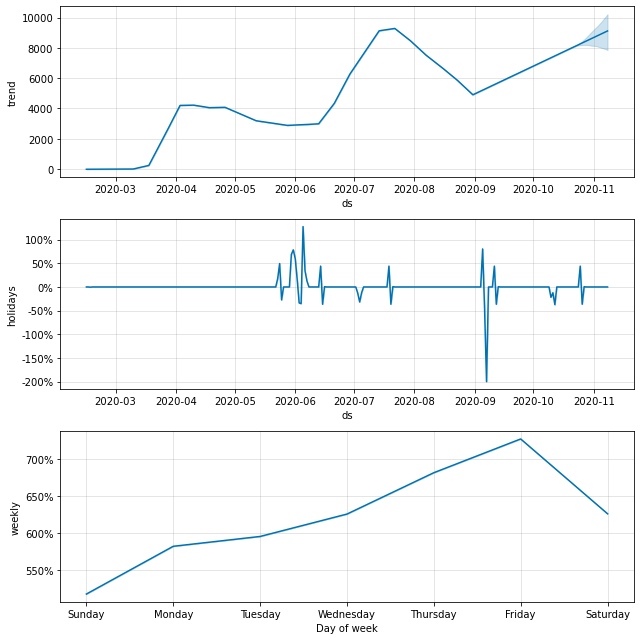

In [27]:
def part4_summary(df, holi,best_params):
    tr,te = train_test_split(df,test_size=0.07,shuffle=False)

    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, holidays=holi,
                    changepoint_prior_scale = best_params['changepoint scale'],seasonality_mode=best_params['season'])
    model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier order'], mode = best_params['season'], 
                              prior_scale = best_params['season scale'])
    model.fit(tr)

    
    future_dates = model.make_future_dataframe(periods=te.shape[0])
    forecast = model.predict(future_dates)
    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    print(training_rmse,test_rmse)
    
    model.plot(forecast);
    model.plot_components(forecast);
    return 

part4_summary(train,pd.read_csv('myholidays.csv'),best_params)

### Part 4 Summary
The manually tuned actually performs marginally better than the holidays from 4.2, but overall did not perform as well as section 4.1. It fits worse regarding the training data than the other two. Section 4.3 was to show that my initial intuition differs from the backend of the Prophet model.

RMSE:
- Train: 3024.228191679621 
- Test: 32700.52890464703

# 5. Hyperparameter Tuning Part 5: Regressors<a class="anchor" id="5"></a>
[Back to Outline](#0)

Prophet allows the inclusion of additional regressors that can be used to finetune the model. These regressors can be thought of as prolonged holidays while not necessarily following a pattern like seasonality. As a response to COVID-19, Google (https://www.google.com/covid19/mobility/) has released mobility data that documents activity in different areas (retail, grocery, etc.). It uses the first month of January and part of February (pre-COVID for US) as a baseline such that subsequent comparisons will be measured as changes from this baseline. 

In [28]:
def format_mobility():
    df = pd.read_csv('2020_US_Region_Mobility_Report.csv').iloc[:289,7:]
    df['date'] = pd.DatetimeIndex(df['date'])
    df.columns=['ds','retail','grocery','parks','transit','work','residential']
    return df

format_mobility()

ds  retail  grocery  parks  transit  work  residential
0   2020-02-15     6.0      2.0   15.0      3.0   2.0         -1.0
1   2020-02-16     7.0      1.0   16.0      2.0   0.0         -1.0
2   2020-02-17     6.0      0.0   28.0     -9.0 -24.0          5.0
3   2020-02-18     0.0     -1.0    6.0      1.0   0.0          1.0
4   2020-02-19     2.0      0.0    8.0      1.0   1.0          0.0
..         ...     ...      ...    ...      ...   ...          ...
284 2020-11-25    -3.0     23.0   -7.0    -30.0 -40.0         10.0
285 2020-11-26   -70.0    -30.0  -13.0    -60.0 -81.0         23.0
286 2020-11-27   -26.0    -20.0    2.0    -47.0 -60.0         19.0
287 2020-11-28   -26.0    -15.0   -1.0    -32.0 -18.0          7.0
288 2020-11-29   -23.0    -15.0  -12.0    -28.0 -16.0          6.0

[289 rows x 7 columns]

A plot shows a similar story with the stringency data set, with variables like residential/transit/work being very similar to each other in terms of trends. Parks seems to be heavily corresponded to nice weather in the summer time as well as holidays like Independence Day and Labor Day giving people time off. The fact that these are more in line with time-series data may lead to better fit to the model.

In [29]:
def plot_mobility(df):
    fig = px.line(df,x='ds',y=['retail','grocery','parks','transit','work','residential'],
                 labels=dict(ds="Date", value="Change from baseline"))
    fig.show()
    return

plot_mobility(format_mobility())

To accept time-series data as regressors, Prophet needs them to be in the same DataFrame that will be fed to the Prophet model for fitting. This function also adds in stringency, as it might have a better time improving the model as a regressor than as a holiday. 

In [30]:
def make_regressors(df):
    gov = format_govresponse().loc[:,['date','stringency']]
    mob = format_mobility()   
    df=df.merge(gov,left_on='ds',right_on='date')
    df=df.merge(mob,left_on='ds',right_on='ds')
    df=df.drop(columns='date')
    return df

multivar_train = make_regressors(train)
multivar_train

ds         y  stringency  retail  grocery  parks  transit  work  \
0   2020-02-15       0.0        5.56     6.0      2.0   15.0      3.0   2.0   
1   2020-02-16       0.0        5.56     7.0      1.0   16.0      2.0   0.0   
2   2020-02-17      10.0        5.56     6.0      0.0   28.0     -9.0 -24.0   
3   2020-02-18       0.0        5.56     0.0     -1.0    6.0      1.0   0.0   
4   2020-02-19       0.0        5.56     2.0      0.0    8.0      1.0   1.0   
..         ...       ...         ...     ...      ...    ...      ...   ...   
263 2020-11-04  107883.0       62.50   -18.0    -10.0    4.0    -36.0 -30.0   
264 2020-11-05  121541.0       62.50   -18.0     -8.0    7.0    -34.0 -30.0   
265 2020-11-06  132872.0       62.50   -18.0    -10.0    6.0    -33.0 -29.0   
266 2020-11-07  125932.0       62.50   -16.0     -6.0   23.0    -27.0 -10.0   
267 2020-11-08  103416.0       62.50   -17.0     -9.0   13.0    -29.0 -14.0   

     residential  
0           -1.0  
1           -1.0  
2            5.0  
3            1.0  
4            0.0  
..           ...  
263         10.0  
264         10.0  
265          9.0  
266          4.0  
267          4.0  

[268 rows x 9 columns]

To act as a regressor, we must ensure that the prediction future dates also have data points for each of these regressors (or, we use another Prophet model to forecast that itself). Each regressor can be changed like seasonalities, I tuned the model to only accept one regressor at a time, so the parameters are:
- Mode: additive or multiplicative
- Regressor: stringency, retail, grocery, parks, transit, work, residential
- Prior scale: 1, 5, 10

In [31]:
def part5_tuning(multivar_train,best_params,holi):
    tr_rmse_list=[]
    te_rmse_list=[]
    for mod in ['additive','multiplicative']:
        for reg in multivar_train.columns[2:]:
            for scale in [1,5,10]:
                tr,te = train_test_split(multivar_train,test_size=0.07,shuffle=False)

                holi['lower_window']=best_params['lower_window']
                holi['upper_window']=best_params['upper_window']
                holi['prior_scale']=best_params['prior_scale']
                model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, holidays=holi,
                                changepoint_prior_scale = best_params['changepoint scale'],seasonality_mode=best_params['season'])
                model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier order'], mode = best_params['season'], 
                                          prior_scale = best_params['season scale'])  

                model.add_regressor(reg,mode=mod,prior_scale=scale)
                model.fit(tr)
                future_dates = model.make_future_dataframe(periods=te.shape[0])

                future_dates= future_dates.merge(multivar_train,left_on='ds',right_on='ds')
                future_dates = future_dates.drop(columns='y')
                forecast = model.predict(future_dates)

                training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
                test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
                tr_rmse_list.append(training_rmse)
                te_rmse_list.append(test_rmse)
                print(mod,reg,scale)
                print(training_rmse,test_rmse)
    pd.DataFrame(data=[tr_rmse_list,te_rmse_list]).T.to_csv("hyperparameter_regressors.csv")
    return 
    
grading_mode=True
if not grading_mode:
    best_params = {'changepoint scale': 0.5,  'fourier order': 12, 'lower_window': -4, 'prior_scale': 5,
                    'season': 'multiplicative',  'season scale': 10, 'upper_window': 1}
    part5_tuning(multivar_train,best_params,make_holiday_df())

Bar charts were made to compare each regressor's performance. For the time-series data from Google, multiplicative was the best performing mode while stringency was by far better with additive. The best performing regressor seemed to be residential.

In [32]:
def plot_part5_hyper():
    hyper_holi=pd.read_csv('hyperparameter_regressors.csv')

    x = [
        ["add", "add", "add", "mult", "mult", "mult"],
        [1, 5, 10, 1, 5, 10]
    ]
    for reg in hyper_holi.loc[:,'reg'].drop_duplicates(): 
        fig = go.Figure()
        fig.add_bar(x=x,y=hyper_holi[hyper_holi.reg==reg].test_rmse)
        if reg=='stringency':
            fig.update_yaxes(range=[31000, 33500])
        else:
            fig.update_yaxes(range=[30500, 32400])

        fig.update_layout(title=reg)

        fig.show()
plot_part5_hyper()

This just looks through the DataFrame, and prints out the best configuration for each regressor in text form instead of visualization form.

In [33]:
hyper_holi=pd.read_csv('hyperparameter_regressors.csv')

for reg in hyper_holi.loc[:,'reg'].drop_duplicates(): 
    best=hyper_holi[hyper_holi.reg==reg].test_rmse.idxmin()
    print("Regressor",reg)
    best_row =hyper_holi.iloc[best]
    print("Mode",best_row['mod'],"Regressor Scale",best_row['reg scale'])
    print("Best RMSE",best_row['test_rmse'])
    print()

Regressor stringency
Mode additive Regressor Scale 10
Best RMSE 32060.65448

Regressor retail
Mode multiplicative Regressor Scale 1
Best RMSE 31687.39924

Regressor grocery
Mode multiplicative Regressor Scale 1
Best RMSE 31865.71195

Regressor parks
Mode multiplicative Regressor Scale 10
Best RMSE 31830.31385

Regressor transit
Mode multiplicative Regressor Scale 10
Best RMSE 31796.092310000004

Regressor work
Mode multiplicative Regressor Scale 1
Best RMSE 32053.708130000003

Regressor residential
Mode multiplicative Regressor Scale 5
Best RMSE 31185.8623



One final tune is made to the model with the regressors. It was found that the best configuration would be to include retail, residential, and work regressors. An intuition might be that groceries will always receive people. Parks seem to be more correlated with temperature and weather. Stringency still did not perform as well.

C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



2850.9392374230874 30731.027724299456


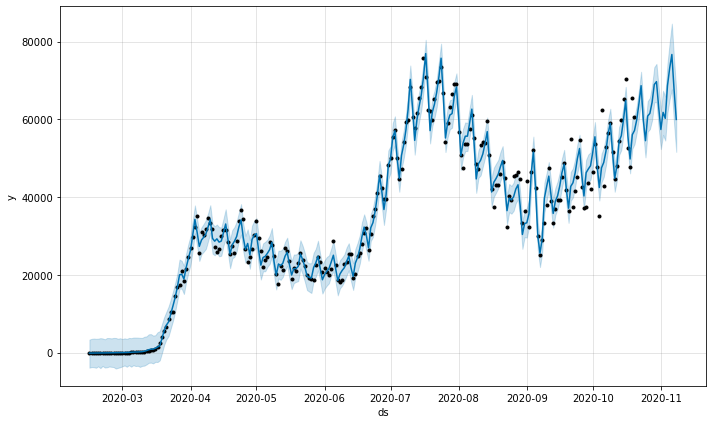

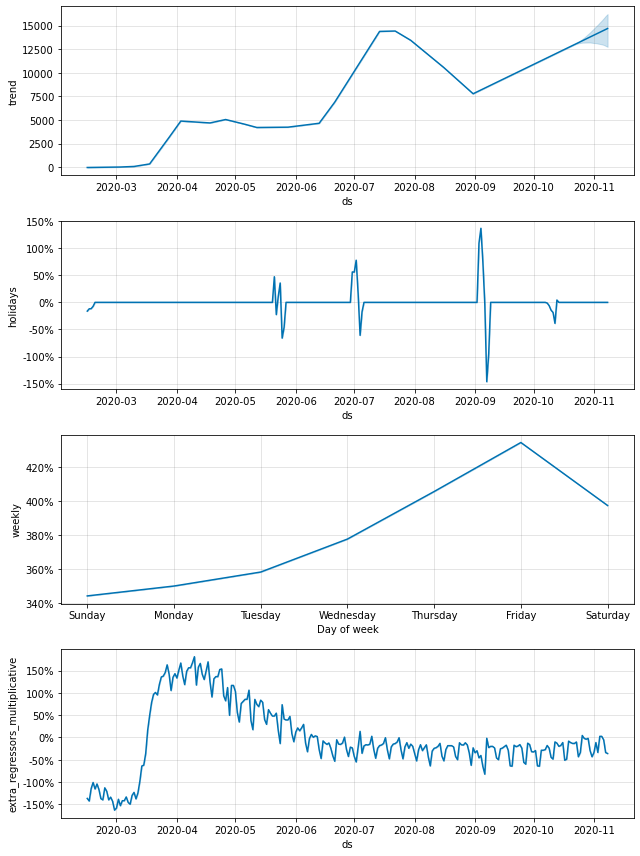

In [34]:
def part5_tune(multivar_train,best_params,holi):
    tr,te = train_test_split(multivar_train,test_size=0.07,shuffle=False)

    holi['lower_window']=best_params['lower_window']
    holi['upper_window']=best_params['upper_window']
    holi['prior_scale']=best_params['prior_scale']
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, holidays=holi,
                changepoint_prior_scale = best_params['changepoint scale'],seasonality_mode=best_params['season'])
    model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier order'], mode = best_params['season'], 
                          prior_scale = best_params['season scale'])  

    model.add_regressor('residential',mode='multiplicative',prior_scale=5)
    model.add_regressor('retail',mode='multiplicative',prior_scale=1)
#    model.add_regressor('transit',mode='multiplicative',prior_scale=10)
#    model.add_regressor('stringency',mode='additive',prior_scale=10)
#    model.add_regressor('parks',mode='multiplicative',prior_scale=10)
#    model.add_regressor('grocery',mode='multiplicative',prior_scale=1)
    model.add_regressor('work',mode='multiplicative',prior_scale=1)

    model.fit(tr)
    future_dates = model.make_future_dataframe(periods=te.shape[0])

    future_dates= future_dates.merge(multivar_train,left_on='ds',right_on='ds')
    future_dates = future_dates.drop(columns='y')
    forecast = model.predict(future_dates)
    model.plot(forecast);
    model.plot_components(forecast);

    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    print(training_rmse,test_rmse)
    return

part5_tune(multivar_train,best_params,make_holiday_df())

### Part 5 Summary
While not performing as well on the training data, the regressors added managed to improve the testing data that was first set by section 4.1. More work should be done regarding the most optiomal regressor configuration out of all 7.

RMSE:
- Train: 2850.9392374230874 
- Test: 30731.027724299456

# 6. Predictions<a class="anchor" id="6"></a>
[Back to Outline](#0)

After a couple series of fine tunings, the final model is shown below.

Seasonality and Trends:
- Seasonality: multiplicative
- Seasonality scale: 10
- Changepoint scale: 0.5
- Fourier order: 12

Holidays:
- Lower window: -4
- Upper window: 1
- Holiday Prior Scale: 5
- Holiday List: no change from https://github.com/dr-prodigy/python-holidays/tree/master/holidays/countries

Regressors:
- Work: multiplicative, scale = 1
- Retail: multiplicative, scale = 1
- Residential: multiplicative, scale = 5

In [35]:
best_params = {'changepoint scale': 0.5,
 'fourier order': 12,
 'lower_window': -4,
 'prior_scale': 5,
 'season': 'multiplicative',
 'season scale': 10,
 'upper_window': 1}
holiday = make_holiday_df()
regressors = {'retail': {'mode': 'multiplicative','prior_scale':1},
             'work': {'mode': 'multiplicative','prior_scale':1},
             'residential': {'mode': 'multiplicative','prior_scale':5}}

Modify the original dataset from section 2 to include all of the regressors.

In [36]:
df_covid = make_regressors(make_proph_df(df_covid_us))
df_covid

ds         y  stringency  retail  grocery  parks  transit  work  \
0   2020-02-15       0.0        5.56     6.0      2.0   15.0      3.0   2.0   
1   2020-02-16       0.0        5.56     7.0      1.0   16.0      2.0   0.0   
2   2020-02-17      10.0        5.56     6.0      0.0   28.0     -9.0 -24.0   
3   2020-02-18       0.0        5.56     0.0     -1.0    6.0      1.0   0.0   
4   2020-02-19       0.0        5.56     2.0      0.0    8.0      1.0   1.0   
..         ...       ...         ...     ...      ...    ...      ...   ...   
284 2020-11-25  180536.0       75.46    -3.0     23.0   -7.0    -30.0 -40.0   
285 2020-11-26  103104.0       75.46   -70.0    -30.0  -13.0    -60.0 -81.0   
286 2020-11-27  205460.0       75.46   -26.0    -20.0    2.0    -47.0 -60.0   
287 2020-11-28  151247.0       75.46   -26.0    -15.0   -1.0    -32.0 -18.0   
288 2020-11-29  136313.0       75.46   -23.0    -15.0  -12.0    -28.0 -16.0   

     residential  
0           -1.0  
1           -1.0  
2            5.0  
3            1.0  
4            0.0  
..           ...  
284         10.0  
285         23.0  
286         19.0  
287          7.0  
288          6.0  

[289 rows x 9 columns]

A prediction will be made to the original testing dataset, and the plots will be shown.

4137.226831227416 56454.527471406596


C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Allen\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



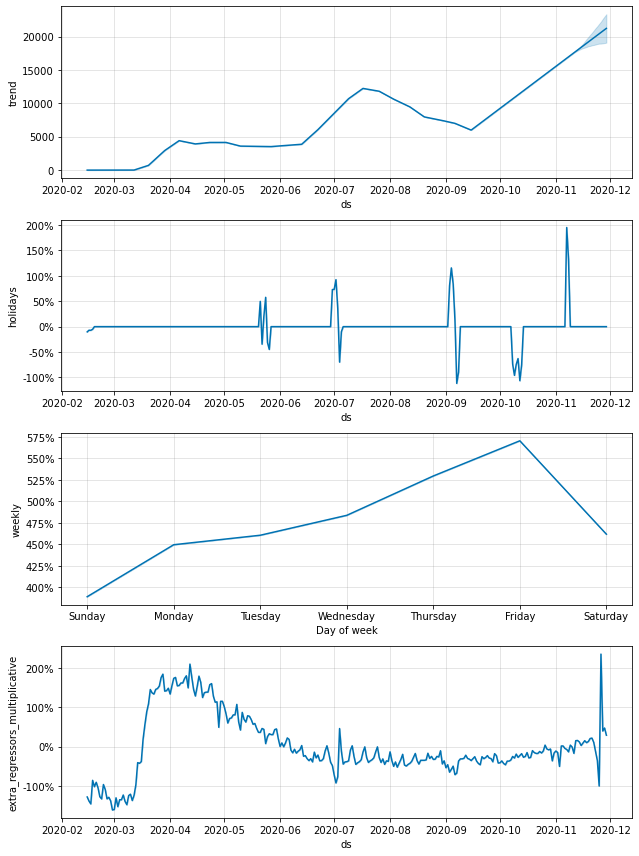

In [37]:
def make_prediction(multivar,holi,best_params):
    tr,te = train_test_split(multivar,test_size=0.07,shuffle=False)

    holi['lower_window']=best_params['lower_window']
    holi['upper_window']=best_params['upper_window']
    holi['prior_scale']=best_params['prior_scale']
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, holidays=holi,
                changepoint_prior_scale = best_params['changepoint scale'],seasonality_mode=best_params['season'])
    model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier order'], mode = best_params['season'], 
                          prior_scale = best_params['season scale'])  

    model.add_regressor('residential',mode='multiplicative',prior_scale=5)
    model.add_regressor('retail',mode='multiplicative',prior_scale=1)
    model.add_regressor('work',mode='multiplicative',prior_scale=1)
    
    model.fit(tr)
    
    future_dates = model.make_future_dataframe(periods=te.shape[0])
    future_dates= future_dates.merge(multivar,left_on='ds',right_on='ds')
    future_dates = future_dates.drop(columns='y')
    forecast = model.predict(future_dates)
    
    model.plot_components(forecast);
    
    training_rmse = np.sqrt(mean_squared_error(tr.loc[:,'y'],forecast.loc[:(tr.shape[0]-1),'yhat']))
    test_rmse = np.sqrt(mean_squared_error(te.loc[:,'y'],forecast.loc[tr.shape[0]:,'yhat']))
    print(training_rmse,test_rmse)    
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tr['ds'], y=tr['y'], name='Train',))
    fig.add_trace(go.Scatter(x=te['ds'], y=te['y'], name='Test',))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
    fig.update_layout(
        title="Forecast prediction of new COVID-19 cases in US",
        xaxis_title="Date",
        yaxis_title="New Cases",
    )

    fig.show()
    
    return
    
make_prediction(df_covid,make_holiday_df(),best_params)

### Prediction summary
- Train RMSE: 4137.226831227416
- Test RMSE: 56454.527471406596

The model does a good job in terms of fitting to the training data. In terms of trends, it even fits well towards the testing data. However, the biggest issue seems to be it misrepresenting the magnitude of the model. Further improvements should be made, including close tuning of individual holidays as well as the influence of regressors. Closer investigation of the political/economic/social reasons of why this COVID-19 spike is occurring would also be a possibility. 


I would like to thank Professor Qi as well as the TAs Jack and Zhe for the help across the entire course. Thank you for all that you have done, and I am excited to apply what I have learned in this class to future work.

[Back to Outline](#0)